In [ ]:
# adding data augmentation 

In [1]:
import numpy as np
import copy
import os
import sys
import math
from tqdm import tqdm
from data import dataset
#from scripts import config

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load data set

In [2]:
# load dataset
# Let's load dataset
dataset_name = 'met'
MET_DATASET_ROOT = '/var/data/MET3'

if dataset_name not in ['met', 'lsp', 'mpii']:
    raise ValueError('Unknown dataset: {}'.format(dataset_name))

if dataset_name == 'mpii':
    TEST_CV_FILEPATH = os.path.join(config.MPII_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.MPII_DATASET_ROOT, 'images')
    symmetric_joints = "[[12, 13], [11, 14], [10, 15], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -100500
elif dataset_name == 'lsp': # LSP dataset
    TEST_CV_FILEPATH = os.path.join(config.LSP_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.LSP_DATASET_ROOT, 'images')
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
elif dataset_name == 'met': # MET dataset
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity1.csv') # test only one image
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity.csv')
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity_with_head.csv')
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity_wo.csv')
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity_wo_ub.csv') # cleaned up
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity_20180618.csv') # joint rechecked! (2018.06.18) 
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity-met_n10.csv') # joint rechecked! (2018.06.18)    
    # for debugging
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'writing46.csv')  # with valid joints info
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'writing46nv.csv')  # without valid joints info
    
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity1.csv')  # without valid joints info

    #TEST_CV_FILEPATH = os.path.join(MET_DATASET_ROOT, 'activity-met_n10_ub_new.csv') # MET3 
    TEST_CV_FILEPATH = os.path.join(MET_DATASET_ROOT, 'activity1.csv') # for debugging
    
    IMG_PATH_PREFIX = os.path.join(MET_DATASET_ROOT)
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
else:
    pass
 
    
print(TEST_CV_FILEPATH)
print(IMG_PATH_PREFIX)

test_dataset = dataset.PoseDataset(
    TEST_CV_FILEPATH,
    IMG_PATH_PREFIX, 227,
    fliplr=False, rotate=False,
    shift=None,
    #bbox_extension_range=(1.0, 1.0),
    bbox_extension_range=(1.4, 1.4),
    coord_normalize=True,
    gcn=True,
    fname_index=0,
    joint_index=1,
    symmetric_joints=symmetric_joints,
    ignore_label=ignore_label,
    should_return_bbox=True,
    should_downscale_images=True,
    downscale_height=400
)

print("dataset with {} images ready".format(len(test_dataset)))

1it [00:00,  5.35it/s]

/var/data/MET3/activity1.csv
/var/data/MET3
Reading dataset from /var/data/MET3/activity1.csv
Downscale image/office activities/filing.seated/3.jpeg to the height 400px
1 images loaded
joints shape: (14, 2)
dataset with 1 images ready


## data augmentation by horizontal flip

In [ ]:
# read one image 

from tools import augment

imageIdx = 0

image=test_dataset.get_original_image(imageIdx)    
image_id, joints = test_dataset.joints[imageIdx]
is_valid_joints, bbox = test_dataset.info[imageIdx]
print(image_id, joints, is_valid_joints, bbox)


# flip the image & joints 
image_flipped, joints_flipped, is_valid_joints_flipped, bbox_flipped = augment.flip_image_and_joints(image, joints, is_valid_joints, test_dataset.symmetric_joints, bbox)


# plot images & joints
plt.subplot(121)
plt.imshow(image[:,:,::-1])
plt.plot(joints[:,0], joints[:,1], 'or')
plt.title('original image & joints')
plt.subplot(122)
plt.imshow(image_flipped[:,:,::-1])
plt.plot(joints_flipped[:,0], joints_flipped[:,1], 'or')
plt.title('flipped image & joints')


In [ ]:
"""
Another way to plot using bbox and normalized joints

from matplotlib import pyplot as plt
%matplotlib inline

imageIdx = 0   # this image has only upper body
img=test_dataset.get_original_image(imageIdx)


image, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx)
valid_joints = joints[is_valid_joints].reshape(-1,2)

#bbox=misc['orig_tightest_bbox']
bbox=misc['bbox']


# plot joints
plt.imshow(img[:,:,::-1])
# plot joints
offsetX = bbox[0]
offsetY = bbox[1]
W = bbox[2]#-bbox[0]
H = bbox[3]#-bbox[1]
print(W,H)
plt.plot((valid_joints[:,0]+0.5)*W+offsetX, (valid_joints[:,1]+0.5)*H+offsetY,'or')
"""

In [ ]:
len(test_dataset)

#image, joints, is_valid_joints, misc = test_dataset.get_example(0)

In [ ]:
# augment image 


import cv2 as cv

from tools import augment

def augmentByFlip(dataset):
    numImages = len(dataset)
    
    symmetric_joints = dataset.symmetric_joints
    

    for i in {0}:
    #for i in range (numImages):
        # get joints & info
        image_id, joints = dataset.joints[i]
        is_valid_joints, bbox = dataset.info[i]
        print(image_id, joints, is_valid_joints, bbox)
        #print(bbox)

        # get image
        image = dataset.images[image_id]

        image_flipped, joints_flipped, is_valid_joints_flipped, bbox_flipped = augment.flip_image_and_joints(image, joints, is_valid_joints, dataset.symmetric_joints, bbox)
        # below code is moved to tools/augment.py
        
        """
        H, W, C = image.shape
        print(W,H,C)

        # flip image
        image_flipped=cv.flip(image,1)

        # flip joints
        joints_flipped = joints.copy()
        joints_flipped[:,0] = W + 1 - joints_flipped[:,0]
        #print(joint_flipped)
        
        is_valid_joints_flipped = is_valid_joints.copy()
        #print(is_valid_joints_flipped)

        # swap symmetric joints!
        for i, j in symmetric_joints:
            joints_flipped[i], joints_flipped[j] = joints_flipped[j].copy(), joints_flipped[i].copy()
            is_valid_joints_flipped[i], is_valid_joints_flipped[j] = is_valid_joints_flipped[j].copy(), is_valid_joints_flipped[i].copy()
        
        print(joints_flipped)
        print(is_valid_joints_flipped)
        
        # flip bbox
        bbox_flipped = bbox.copy()
        bbox_flipped[0] = W + 1 - (bbox_flipped[0] + bbox_flipped[2])
        print(bbox_flipped)
        """
        

        # add to the dataset
        image_id_flipped = image_id+'_FLR'
        dataset.images[image_id_flipped] = image_flipped

        dataset.joints.append((image_id_flipped, joints_flipped))
        dataset.info.append((is_valid_joints, bbox_flipped))

        
        # plot!
        plt.imshow(image_flipped[:,:,::-1])
        # plot joints
        offsetX = bbox_flipped[0]
        offsetY = bbox_flipped[1]
        W = bbox_flipped[2]
        H = bbox_flipped[3]
        valid_joint_flipped = joints_flipped*is_valid_joints_flipped
        #valid_joint_flipped = joint_flipped[is_valid_joints_flipped]# .reshape(-1,2)
        
        print(valid_joint_flipped)

        plt.clf
        plt.plot(valid_joint_flipped[:,0], valid_joint_flipped[:,1],'or')  # not-normalized
        #plt.plot((valid_joint_flipped[:,0]+0.5)*W+offsetX, (valid_joint_flipped[:,1]+0.5)*H+offsetY,'or')

        
augmentByFlip(test_dataset)

        

In [ ]:
## moved to scripts/dataset.py
print(len(test_dataset))
test_dataset.augmentByFlip()
print(len(test_dataset))

## Next is to apply rotation!

In [ ]:
from tools import augment
%load_ext autoreload
%autoreload 2




imageIdx = 0

image=test_dataset.get_original_image(imageIdx)    
image_id, joints = test_dataset.joints[imageIdx]
is_valid_joints, bbox = test_dataset.info[imageIdx]
print(image_id, joints, is_valid_joints, bbox)


degree = 10
center= joints[12,:] # neck

center_hip = np.mean(joints[2:4,:],axis=0)
print(center_hip)
center_torso =  (center_hip + joints[12,:]) * 0.5
print(center_torso)



# rotate the image & joints 
#image_flipped, joints_flipped, is_valid_joints_flipped, bbox_flipped = augment.flip_image_and_joints(image, joints, is_valid_joints, test_dataset.symmetric_joints, bbox)
image_rotated, joints_rotated, is_valid_joints_rotated = augment.rotate_image_and_joints(image, joints, is_valid_joints, center_torso, degree)

# to test invalid joints
#image_rotated, joints_rotated, is_valid_joints_rotated = augment.rotate_image_and_joints(image, joints, is_valid_joints, (100,150), degree)

print(joints_rotated, is_valid_joints_rotated)


# plot images & joints
plt.subplot(121)
plt.imshow(image[:,:,::-1])
plt.plot(joints[:,0], joints[:,1], 'or')
plt.title('original image & joints')
plt.subplot(122)
plt.imshow(image_rotated[:,:,::-1])
plt.plot(joints_rotated[:,0], joints_rotated[:,1], 'or')
plt.title('rotated image & joints')



In [ ]:
## moved to scripts/dataset.py
print(len(test_dataset))
test_dataset.augmentByRotation((-10,-5,5,10))
print(len(test_dataset))

In [ ]:
for i in range(5):
    plt.subplot(1,5,i+1)
    image, joints, is_valid_joints = test_dataset.get_image_and_joints(i)  # simplified to a method!
    plt.imshow(image[:,:,::-1])
    plt.plot(joints[:,0], joints[:,1], 'or')



In [ ]:
(-10,-5,5,10)

## Next, shift

In [ ]:
# let's test the cropping function

imageIdx = 0

image=test_dataset.get_original_image(imageIdx)    

image_id, joints = test_dataset.joints[imageIdx]
is_valid_joints, bbox = test_dataset.info[imageIdx]
print(image_id, joints, is_valid_joints, bbox)


image_cropped, joints_cropped, bbox_cropped, bbox_origin = test_dataset.apply_cropping(image, joints, bbox, bbox_extension_range=None, shift=None)

print('cropped')
#print(image_id, joints, is_valid_joints, bbox)



In [ ]:

plt.subplot(121)
plt.imshow(image[:,:,::-1])

plt.subplot(122)
plt.imshow(image_cropped[:,:,::-1])
plt.plot(joints_cropped[:,0], joints_cropped[:,1],'or')


In [ ]:
print(image_id, joints, is_valid_joints, bbox)
print(joints_cropped, bbox_cropped, bbox_origin)

## augment shuffled data

In [ ]:
from scripts import dataset 

def loadDataset(filename):

    dataset_name = 'met'

    TEST_CV_FILEPATH = '/var/data/MET2/' + filename
    IMG_PATH_PREFIX = '/var/data/MET2'
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1

    print(TEST_CV_FILEPATH)
    print(IMG_PATH_PREFIX)

    test_dataset = dataset.PoseDataset(
        TEST_CV_FILEPATH,
        IMG_PATH_PREFIX, 227,
        fliplr=False, rotate=False,
        shift=None,
        #bbox_extension_range=(1.0, 1.0),
        bbox_extension_range=(1.4, 1.4),
        coord_normalize=True,
        gcn=True,
        fname_index=0,
        joint_index=1,
        symmetric_joints=symmetric_joints,
        ignore_label=ignore_label,
        should_return_bbox=True,
        should_downscale_images=True,
        downscale_height=400
    )
    
    return test_dataset

In [ ]:
numClass = 10

for k in range(5):
#for k in range(1):
    train_filename = "activity-met_n{}_ub_train_k{}.csv".format(numClass, k)
    train_dataset = loadDataset(train_filename)
    #print(filename)
    
    val_filename = "activity-met_n{}_ub_val_k{}.csv".format(numClass, k)
    val_dataset = loadDataset(val_filename)
    #print(filename)
    
    print(train_filename)
    print(len(train_dataset))
    print(val_filename)
    print(len(val_dataset))

    
    # augment the training data set by rotation & horizontal flip
    train_dataset.augmentByRotation((-5,5), removeInvalidJoints=False)
    train_dataset.augmentByFlip()
    print(len(train_dataset))
    
    train_filename_augmented = "activity-met_n{}_ub_train_k{}_augmented.csv".format(numClass, k)
    train_dataset.to_csv(train_filename_augmented)
    
    val_dataset.augmentByRotation((-5,5), removeInvalidJoints=False)
    val_dataset.augmentByFlip()
    print(len(val_dataset))
    
    val_filename_augmented = "activity-met_n{}_ub_val_k{}_augmented.csv".format(numClass, k)
    val_dataset.to_csv(val_filename_augmented)
        
    
    
    
    
    
    


## Let's understand bbox

In [3]:
# get an image
imageIdx = 0

image=test_dataset.get_original_image(imageIdx)    
image_id, joints = test_dataset.joints[imageIdx]
is_valid_joints, bbox = test_dataset.info[imageIdx]
print(image_id, joints, is_valid_joints, bbox)

image/office activities/filing.seated/3.jpeg [[ 48.71031746 323.31349206]
 [104.96031746 273.90873016]
 [ 63.29365079 237.99603175]
 [102.28174603 232.63888889]
 [146.92460317 254.66269841]
 [148.41269841 323.31349206]
 [172.81746032 172.61904762]
 [126.68650794 165.97222222]
 [ 82.83730159 142.65873016]
 [111.70634921 175.29761905]
 [133.03571429 204.66269841]
 [165.67460317 218.65079365]
 [103.86904762 145.23809524]
 [123.71031746 112.59920635]] [[1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]] [ 48.71031746 112.59920635 124.10714286 210.71428571]


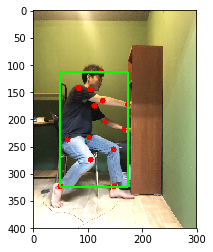

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

import cv2 as cv 

# plot joints
for i in range(joints.shape[0]):
    x=int(joints[i,0]+0.5)
    y=int(joints[i,1]+0.5)

    cv.circle(image, (x, y), 5, (0,0,255), -1)
    
# plot bbox 
bbox_int = [int(i+0.5) for i in bbox]
cv.rectangle(image,(bbox_int[0],bbox_int[1]),(bbox_int[0]+bbox_int[2],bbox_int[1]+bbox_int[3]),(0,255,0),2)

plt.imshow(image[:,:,::-1])

## bbox is too tight!

In [37]:
## Understand cropping function

def enlarge_bbox(bbox, shape, ratio):
    bbox_enlarged = bbox.copy()
    
    x = bbox_enlarged[0]
    y = bbox_enlarged[1]
    w = bbox_enlarged[2]
    h = bbox_enlarged[3]
    #print(x,y,w,h)
    
    left = 0.5*ratio*w
    right = 0.5*ratio*w
    top = 0.5*ratio*h
    bottom = 0.5*ratio*h

    # enlarge bbox to the left
    x = x - left
    np.clip(x, 0, shape[1])
    
    w = w + (bbox[0]-x)
    
    # enlarge bbox to the right
    w = w + right
    np.clip(w, 0, shape[1]-x)

    bbox_enlarged[0] = x
    bbox_enlarged[2] = w
    

    # enlarge bbox to the top
    y = y - top
    np.clip(y, 0, shape[0])
    
    h = h + (bbox[1]-y)    
    
    # enlarge bbox to the bottom
    h = h + bottom
    np.clip(h, 0, shape[0]-y)

    # 
    bbox_enlarged[1] = y
    bbox_enlarged[3] = h
    
    
    

        
    # enlarge bbox to the right
    #bbox_enlarged[2] = bbox_enlarged[2] + 0.1*w
    

    return bbox_enlarged



print(bbox)
bbox_enlarged = enlarge_bbox(bbox, image.shape, 0.5)
print(bbox_enlarged)



valid_joints = test_dataset.get_valid_joints(joints, is_valid_joints)
image_crop, valid_joints_crop, bbox_crop, bbox_origin = test_dataset.apply_cropping(image, valid_joints, bbox_enlarged)
                                                        #                            bbox_extension_range = (1, 1))
                                                        #bbox_extension_range=bbox_extension_range,
                                                        #shift=shift)

#print(bbox_origin)

[ 48.71031746 112.59920635 124.10714286 210.71428571]
[ 17.68353175  59.92063492 186.16071429 316.07142857]


[[ 31.71031746 264.31349206]
 [ 87.96031746 214.90873016]
 [ 46.29365079 178.99603175]
 [ 85.28174603 173.63888889]
 [129.92460317 195.66269841]
 [131.41269841 264.31349206]
 [155.81746032 113.61904762]
 [109.68650794 106.97222222]
 [ 65.83730159  83.65873016]
 [ 94.70634921 116.29761905]
 [116.03571429 145.66269841]
 [148.67460317 159.65079365]
 [ 86.86904762  86.23809524]
 [106.71031746  53.59920635]] [  0   0 187 317] [17 59]


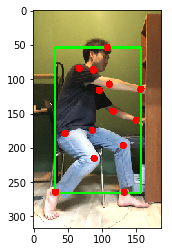

In [38]:
print(valid_joints_crop, bbox_crop, bbox_origin)
plt.imshow(image_crop[:,:,::-1])
for i in range(valid_joints_crop.shape[0]):
    x = valid_joints_crop[i,0]
    y = valid_joints_crop[i,1]    
    plt.plot(x,y,'or')